In [1]:
%matplotlib inline

# Determining Next Character with a Character-Level RNN

*This is a simple proof of concept neural network. We will attempt to overfit on a single file of Python source code.*

Build a character level recurrent neural network that:
* Given a sequence of characters, predicts the next likely character in the sequence.

The following are necessary term defintions:

* **Vocabulary**: Set of all characters that our text consists of. Size of vocabulary is the number of unique characters in our text.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from random import shuffle
from math import floor
from time import time

## Preparing the Data
We will be predicting for a single Python file, named `test.py`.


In [3]:
with open("./data/test.py", "r") as f:
    text = f.read()

print(text)

# add a special characters for padding, file_start, and file_stop
# PAD characters are necessary batching, but we will do that in another notebook.
# For now, assume batch_size of 1
# See dynamic_sliding_window_generator
PAD = "<p>"
FILE_START = chr(2) # chr(2) is ASCII start of text
FILE_END = chr(3)   # chr(3) is ASCII end of text

characters = tuple(set(text)) + tuple((PAD, FILE_START, FILE_END))
int2char = dict(enumerate(characters))
char2int = {char: index for index, char in int2char.items()}

# encode text using the character to integer dictionary
encoded = np.array([char2int[char] for char in text])
print("~" * 40)
print("* Vocabulary Size: {}".format(len(characters)))
print("* Text Size: {}".format(len(encoded)))

"""Predict Test"""
import sys
from os import getcwd

def main():
    sys.stdout.write(getcwd())
    for i in range(0, 10):
        print("{} : Boop".format(i), i)
    return False

if __name__ == "__main__":
    main()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
* Vocabulary Size: 39
* Text Size: 219


## Sliding Window Algorithm

Given some iterable, we want a generator that yields X, Y pairs for evaluation.

We want a sequence of a given context length as X, and the next character as Y.

In [4]:
def sliding_window_generator(iterable, window_size, pad_char=PAD):
    """Generator that returns sliding window (X,Y) pairs over the provided iterable"""
    # to generate first character, use PAD, PAD, ..., iterable[0], with output iterable[1]
    for window_idx in range(1, len(iterable)):
        x = iterable[:window_idx]
        if len(x) < window_size:
            x = ((pad_char,) * (window_size - len(x))) + x

        x = x[-window_size:]
        y = iterable[window_idx]
        yield x, y
        
def dynamic_sliding_window_generator(iterable, max_window_size=None, gen_forever=True, shuffle_data=True):
    if max_window_size is None:
        max_window_size = len(iterable)
    while True:
        if shuffle_data:
            data_pairs = []
        for window_idx in range(1, len(iterable)):
            x = iterable[:window_idx]
            if len(x) > max_window_size:
                x = x[-max_window_size:]
            y = iterable[window_idx]

            if shuffle_data:
                data_pairs.append((x, y))
            else:
                yield x, y
        if shuffle_data:
            shuffle(data_pairs)
            while data_pairs:
                x, y = data_pairs.pop()
                yield x, y
        if not gen_forever:
            break
        

Here are the first 3 generator outputs, given a window size of 7.

In [5]:
file_char_seq = (FILE_START,) + tuple(text) + (FILE_END, )
gen = sliding_window_generator(file_char_seq, 7)

for _ in range(0, 3):
    x, y = next(gen)
    print("X: ", x)
    print("Y: ", repr(y))
    print("~" * 20)

X:  ('<p>', '<p>', '<p>', '<p>', '<p>', '<p>', '\x02')
Y:  '"'
~~~~~~~~~~~~~~~~~~~~
X:  ('<p>', '<p>', '<p>', '<p>', '<p>', '\x02', '"')
Y:  '"'
~~~~~~~~~~~~~~~~~~~~
X:  ('<p>', '<p>', '<p>', '<p>', '\x02', '"', '"')
Y:  '"'
~~~~~~~~~~~~~~~~~~~~


Here are the first outputs using the **dynamic** generator with no padding and shuffling enabled, given a max window size of 7. Notice how the padding character is no longer necessary.

In [6]:
file_char_seq = (FILE_START,) + tuple(text) + (FILE_END, )
gen = dynamic_sliding_window_generator(file_char_seq, 7, gen_forever=False)

# for _ in range(0, 3):
#     x, y = next(gen)
for x, y in gen:
    if len(x) < 7:
        print("X: ", x)
        print("Y: ", repr(y))
        print("~" * 20)

X:  ('\x02', '"', '"', '"', 'P', 'r')
Y:  'e'
~~~~~~~~~~~~~~~~~~~~
X:  ('\x02',)
Y:  '"'
~~~~~~~~~~~~~~~~~~~~
X:  ('\x02', '"', '"')
Y:  '"'
~~~~~~~~~~~~~~~~~~~~
X:  ('\x02', '"', '"', '"', 'P')
Y:  'r'
~~~~~~~~~~~~~~~~~~~~
X:  ('\x02', '"')
Y:  '"'
~~~~~~~~~~~~~~~~~~~~
X:  ('\x02', '"', '"', '"')
Y:  'P'
~~~~~~~~~~~~~~~~~~~~


### Utilize CUDA & GPU
Trainng neural networks can be slow. Utilize GPUs if they are available.

In [7]:
device = torch.device("cpu")
HAS_GPU = False
if torch.cuda.is_available():
    HAS_GPU = True
    print("CUDA is available")
    print(" • Number of CUDA devices: {}".format(torch.cuda.device_count()))
    device = torch.device("cuda")
    print(" • Current Device Name: {}".format(torch.cuda.get_device_name(device)))
    print(" • Device CUDA Capability: {}".format(torch.cuda.get_device_capability(device)))

else:
    print("CUDA is not available.")
    
# force GPU off.
HAS_GPU = False
device = torch.device("cpu")

CUDA is available
 • Number of CUDA devices: 1
 • Current Device Name: TITAN Xp
 • Device CUDA Capability: (6, 1)


## Characters to Tensors
Now that we have our inputs and outputs, they must be converted into Tensors for training.

To represent a single character, a one-hot vector of size `(1, num_chars)` is used.
* One-hot vector is filled with zeros except for a one at the index of the current letter.

To make a training example, we join a bunch of these characters into a matrix of size `(window_size, 1, num_chars)`.

The extra `1` dimension is necessary because PyTorch requires everything to be in batches.

In [8]:
def char_to_tensor(char, num_chars=len(characters)):
    tensor = torch.zeros(1, num_chars, device=device)
    tensor[0][char2int[char]] = 1
    return tensor

def charseq_to_tensor(charseq, num_chars=len(characters)):
    tensor = torch.zeros(len(charseq), 1, num_chars, device=device)
    for seq_idx, char in enumerate(charseq):
        tensor[seq_idx][0][char2int[char]] = 1
    return tensor

Here are the tensor inputs and outputs for the generator function we defined earlier.

In [9]:
gen = dynamic_sliding_window_generator(file_char_seq, 7)

x, y = next(gen)

x_tensor = charseq_to_tensor(x)
y_tensor = char_to_tensor(y)

print(x)
print(x_tensor.size())
print(repr(y))
print(y_tensor.size())
print(y_tensor)

('t', 'e', '(', 'g', 'e', 't', 'c')
torch.Size([7, 1, 39])
'w'
torch.Size([1, 39])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


## Creating the Network

Time to create our recurrent neural network. We are extending the basic RNN module provided by the [char_rnn_classification_tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) first, before moving into more complicated networks.

In [10]:
class PureRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PureRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.input2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.input2output = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_val, hidden):
        combined = torch.cat((input_val, hidden), 1)
        hidden = self.input2hidden(combined)
        pre_output = self.input2output(combined)
        output = self.softmax(pre_output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

Initialize our simple recurrent neural network with values appropriate for our character predition task.

In [11]:
# hidden layer output vector size
n_hidden = 128
n_chars = len(characters)

# Input is a single character, 128 hidden units of state, Output is a single character 
char_rnn = PureRNN(n_chars, n_hidden, n_chars)
if HAS_GPU:
    char_rnn.cuda()

Before each file, we should zero out the RNN hidden state.

For `PureRNN`, our starting sequence should always be the file start character.

In [12]:
input_val = char_to_tensor(FILE_START)
hidden_val = char_rnn.init_hidden()

output, next_hidden = char_rnn(input_val, hidden_val)

# more efficient to make the whole file into one tensor and iterate over each character
input_seq = charseq_to_tensor(file_char_seq)
input_val = input_seq[0]
hidden_val = char_rnn.init_hidden()

output, next_hidden = char_rnn(input_val, hidden_val)
print(input_val.size())
print(output.size())
print(next_hidden.size())

torch.Size([1, 39])
torch.Size([1, 39])
torch.Size([1, 128])


## Preparing to Train our Model

We want to evaluate the accuracy of our model in predicting the next character, it is helpful to be able to convert the network prediction back to a human readable character.

In [13]:
def char_from_output(output):
    """Covnvert network output prediction back to readable character"""
    # return the k largest elements of the given tensor
    top_n, top_i = output.topk(1)
    char_index = top_i[0].item()
    return int2char[char_index], char_index
    
char_from_output(output)

('w', 21)

Now, all we need to do is to show the network examples, have it make predictions, and inform the network when predictions are incorrect.

For the loss function, `nn.NLLLoss` is used as the last layer of the RNN is a `nn.LogSoftmax`.

Different loss functions that can be used are defined in [pyTorch Loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions).

For classifing input into `C` number of classes, the following loss functions are useful:

* **Cross Entropy Loss**: [CrossEntropyLoss docs](https://pytorch.org/docs/stable/nn.html#crossentropyloss)
* **Negative Log Likelihood Loss**: [NLLLoss docs](https://pytorch.org/docs/stable/nn.html#nllloss)


In [14]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

Each training loop will:
0. Create input and target tensors
0. Initialize a zerored hidden state
0. Read each letter in and keep the hidden state for the next letter
0. Compare the final output to the target
0. Back-propagate
0. Return the output and loss

In [15]:
learning_rate = 0.005

def train(true_output_tensor, char_sequence_tensor):
    char_rnn.train()
    hidden = char_rnn.init_hidden()
    
    # Sets gradients of all model parameters to zero
    char_rnn.zero_grad()
    
    for i in range(char_sequence_tensor.size()[0]):
        output, hidden = char_rnn(char_sequence_tensor[i], hidden)

    # diagnose datatype error
    # import pdb; pdb.set_trace()

    loss = criterion(output, true_output_tensor)
    loss.backward()
    
    for p in char_rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

## Training our Model

We will now train our model. Keep track of loss for plotting.

In [16]:
n_epochs = 200
print_every = 347
window_size = 15

file_char_seq = (FILE_START,) + tuple(text) + (FILE_END, )

# Keep track of losses for plotting
all_losses = []

def time_since(since):
    delta = time() - since
    sec = int(delta)
    mins = floor(sec / 60)
    sec -= mins * 60
    return "{}m {:0>2d}s".format(mins, sec)

start = time()
iter_idx = 0

# This generator will terminate when it finishes the file.
for epoch_idx in range(n_epochs):
    #gen = sliding_window_generator(file_char_seq, window_size)
    gen = dynamic_sliding_window_generator(file_char_seq, max_window_size=window_size, gen_forever=False)
    for input_char_seq, output_char in gen:
        input_seq_tensor = charseq_to_tensor(input_char_seq)

        # output_tensor = char_to_tensor(output_char)
        # NLLLoss expects the output tensor to be datatype long index of expected character
        output_tensor = torch.tensor([char2int[output_char]], dtype=torch.long, device=device)
        output, loss = train(output_tensor, input_seq_tensor)
        
        # Print iter number, loss, name and guess
        if iter_idx % print_every == 0:
            guess, guess_i = char_from_output(output)
            correct = "✓" if guess == output_char else "✗ ({})".format(output_char)
            print("{:5d} {:.1f}% ({}) {:.5f} | {} {}".format(
                epoch_idx, epoch_idx/n_epochs * 100, time_since(start),
                loss, repr(guess), repr(correct)))
        iter_idx += 1

    # Add current loss avg to list of losses after each epoch
    all_losses.append(loss)


    0 0.0% (0m 00s) 3.68619 | 'P' '✗ ( )'
    1 0.5% (0m 00s) 3.54114 | ' ' '✗ (i)'
    3 1.5% (0m 01s) 3.03981 | ' ' '✗ (s)'
    4 2.0% (0m 02s) 3.28431 | ' ' '✗ (\n)'
    6 3.0% (0m 02s) 3.47256 | ' ' '✗ (()'
    7 3.5% (0m 03s) 2.87691 | ' ' '✗ (i)'
    9 4.5% (0m 04s) 4.01597 | ' ' '✗ (w)'
   11 5.5% (0m 04s) 4.38393 | ' ' '✗ (0)'
   12 6.0% (0m 05s) 1.44911 | ' ' '✓'
   14 7.0% (0m 06s) 3.26367 | ' ' '✗ (")'
   15 7.5% (0m 06s) 1.13099 | ' ' '✓'
   17 8.5% (0m 07s) 2.59768 | ' ' '✗ (r)'
   18 9.0% (0m 08s) 3.18260 | ' ' '✗ (()'
   20 10.0% (0m 08s) 3.41686 | ' ' '✗ ())'
   22 11.0% (0m 09s) 1.01200 | ' ' '✓'
   23 11.5% (0m 10s) 5.30249 | ' ' '✗ (B)'
   25 12.5% (0m 11s) 4.05596 | '\n' '✗ (,)'
   26 13.0% (0m 11s) 3.53704 | '\n' '✗ (s)'
   28 14.0% (0m 12s) 3.20465 | 'r' '✗ (e)'
   29 14.5% (0m 13s) 3.21681 | ' ' '✗ (_)'
   31 15.5% (0m 13s) 2.28460 | 'i' '✓'
   33 16.5% (0m 14s) 1.45841 | ' ' '✗ (i)'
   34 17.0% (0m 15s) 0.83538 | ' ' '✓'
   36 18.0% (0m 15s) 3.24922 | 't' '✗ (m)

## Plotting the Training Process

Plotting the historical loss from `all_losses` shows the network learning!

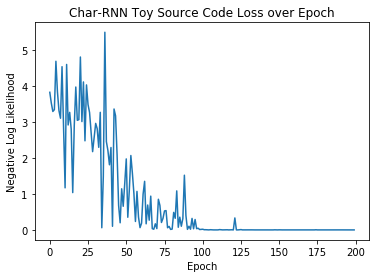

In [17]:
plt.figure()
plt.title("Char-RNN Toy Source Code Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")
plt.plot(all_losses)

## Evaluating our Model Results

Are there certain characters that the network predicts better than others?

How well can the neural network predict each character? We can visualize this using a confusion matrix.

In [18]:
# Keep track of correct guesses in a confusion matrix
n_predictabchars = len(characters)
confusion = np.zeros((n_chars, n_chars))
n_confusion = 1000

gen = dynamic_sliding_window_generator(file_char_seq, window_size)

def evaluate(line_tensor, hidden = char_rnn.init_hidden()):
    char_rnn.eval()
    """Return an output, given a line."""
    for i in range(line_tensor.size()[0]):
        output, hidden = char_rnn(line_tensor[i], hidden)
    return output, hidden


# Keep track of a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    input_char_seq, true_output_char = next(gen)
    true_output_idx = char2int[true_output_char]

    input_seq_tensor = charseq_to_tensor(input_char_seq)
    pred_output_tensor, _ = evaluate(input_seq_tensor)
    pred_output_char, pred_output_idx = char_from_output(pred_output_tensor)
    
    confusion[true_output_idx][pred_output_idx] += 1

# Normalize by dividing every row by its sum
for i in range(confusion.shape[0]):
    row_sum = confusion[i].sum()
    if row_sum <= 0:
        # the next discretely distinguishable floating point value greater than zero
        row_sum = np.nextafter(0,1) 
    confusion[i] = confusion[i] / row_sum

The confusion matrix can now be plotted. 

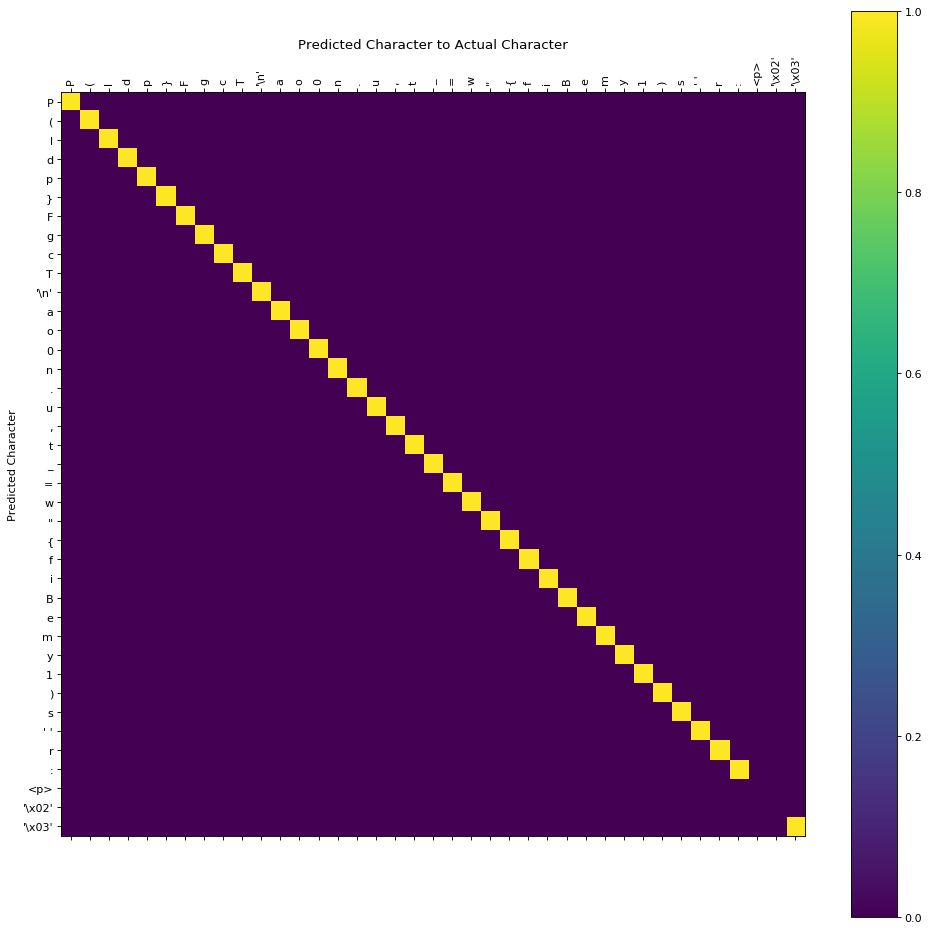

In [19]:
# Plot the confusion matrix
fig = plt.figure(figsize=(15, 15), dpi=80)
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)

# Setup Axes labels, make whitespace more readable
char_labels = [val for key, val in sorted(int2char.items())]
for idx, char_label in enumerate(char_labels):
    if char_label in [" ", "\n", FILE_START, FILE_END]:
        char_labels[idx] = repr(char_label)
ax.set_xticklabels([""] + char_labels, rotation=90)
ax.set_yticklabels([""] + char_labels)

# Force a label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# plt.xlabel("Actual Charcter")
plt.ylabel("Predicted Character")
plt.title("Predicted Character to Actual Character")
plt.show()

## Using User Specified Input

You can test this yourself by supplying your own prelimiary Python source code.

In [20]:
def predict(input_char_seq, max_len=1000):
    print("".join(input_char_seq))
    print("~~~~~Auto Completion~~~~~")
    with torch.no_grad():
        print("".join(input_char_seq), end="")
        output, hidden = evaluate(charseq_to_tensor(input_char_seq))

        for i in range(max_len):
            # Suggestion: Maybe probabalistically choose using weights over all choices?
            topv, topi = output.topk(1, 1, True)        
            # value = topv[0][0].item()
            char_idx = topi[0][0].item()
            next_char = int2char[char_idx]
            if next_char == FILE_END:
                return
            print(next_char, end="")
            input_char_seq = input_char_seq + (next_char, )
            output, hidden = evaluate(charseq_to_tensor(input_char_seq[-window_size:]))
        print("\n~~~~~max_len reached~~~~~")

# this is symbolic, to demonstrate that we have memorized the training data.
CODE = (FILE_START,)
predict(tuple(CODE))


~~~~~Auto Completion~~~~~
"""Predict Test"""
import sys
from os import getcwd

def main():
    sys.stdout.write(getcwd())
    for i in range(0, 10):
        print("{} : Boop".format(i), i)
    return False

if __name__ == "__main__":
    main()


Does it work with your own data? Some arbitrary starting text?

In [21]:
# replace CODE with your own sequence of characters
CODE = "ale"
predict(tuple(CODE))

ale
~~~~~Auto Completion~~~~~
ale"
"ee rent(")
 "  o p r oransr"
f i rd= en 
a ses0i  0 nam":{ :  " s.stsrut.wror"tgrtcwd())
  m  ot i immp"rediys f or oprimpog i:
    maicpddF t" syi)poot ifep"rtpdel da
se
pm t pn

 i  o s prot "apiewdietcft
r"ef : Borpn_t = (0
ie
Fes : s  mmfoouint(_mai(e)c   :  m mainm)"{
 : sm rsy or rapie()ie
: )    f rmnimstw)
g t r m in rmpsy( , s0 r m on rmpie( iescet

dof )
 o  nrttcrin )" "e
fit 0 in
r"

Next approaches will involve using Gated Recurrent Units and LSTM units. 